In [1]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report
import scipy.stats
import math
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import myutils

spell = Speller(lang='en')
nltk.download('stopwords')
nltk.download('punkt')
tk = RegexpTokenizer(r'\w+')


schemas = ["vulnerable", "angry", "impulsive", "happy", "detached", "punishing", "healthy"]
num_of_schemas = 7
max_words = 2000
max_epochs = 30
vec_size = 500

C:\Users\Irene Park\anaconda3\envs\ResearchProject\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Per Questionnaire Classification
This classification is similar to binary classification except the labelling.


Accuracy:  0.3719806763285024
F1 Score:  0.513763791602578
              precision    recall  f1-score   support

  vulnerable       0.15      0.03      0.05        65
       angry       0.15      0.02      0.04        83
   impulsive       0.10      0.03      0.04        40
       happy       0.76      0.95      0.84       156
    detached       0.17      0.04      0.06        56
   punishing       0.10      0.02      0.04        47
     healthy       0.93      0.99      0.96       192

   micro avg       0.75      0.54      0.63       639
   macro avg       0.34      0.30      0.29       639
weighted avg       0.53      0.54      0.51       639
 samples avg       0.80      0.67      0.69       639

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
vulnerable & 0.15 & 0.03 & 0.05 & 65\\
angry & 0.15 & 0.02 & 0.04 & 83\\
impulsive & 0.1 & 0.

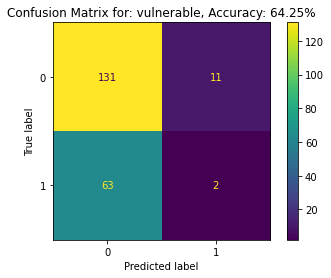

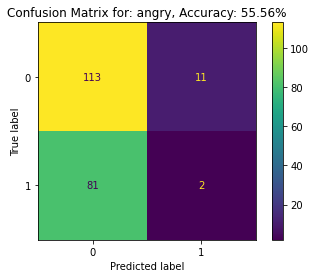

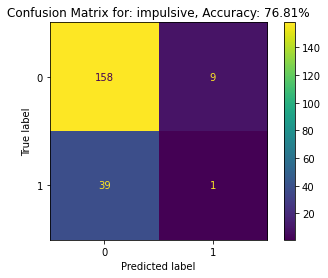

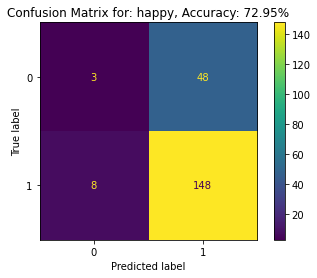

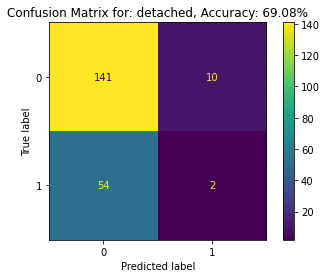

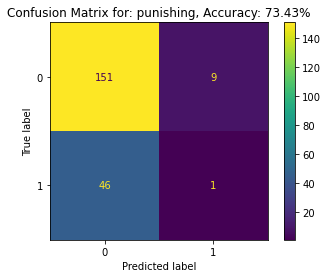

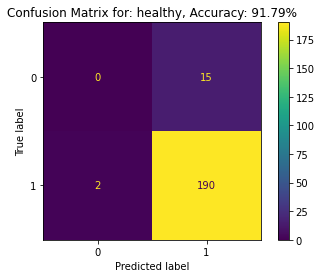

In [2]:
def per_questionnaire_poly():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_range_of_label(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    # from sklearn import preprocessing
    # x_train = preprocessing.scale(x_train) 
    #  C=0.1, gamma=0.1, degree=4
    model_to_set = svm.SVC(kernel="poly")
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    each_accuracy = []

    y_test_bin = myutils.rank_the_labels(y_test)
    schema_test_pred_bin = myutils.rank_the_labels(schema_test_pred)
    y_test_bin = np.array(y_test_bin)
    schema_test_pred_bin = np.array(schema_test_pred_bin)

    print("Accuracy: ", accuracy_score(y_test_bin, schema_test_pred_bin))
    print('F1 Score: ', f1_score(y_test_bin, schema_test_pred_bin, average='weighted'))

    clf_report = classification_report(y_test_bin, schema_test_pred_bin, target_names=schemas)
    print(clf_report)
    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))

    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test_bin, schema_test_pred_bin)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test_bin)).plot()
        accuracy_calc = accuracy_score(y_true=y_test_bin[:,i-1], y_pred=schema_test_pred_bin[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.show()
        i += 1
        
per_questionnaire_poly()

Accuracy:  0.03864734299516908
F1 Score:  0.667455097772387
              precision    recall  f1-score   support

  vulnerable       0.34      0.83      0.48        65
       angry       0.39      0.76      0.51        83
   impulsive       0.20      0.62      0.30        40
       happy       0.75      0.88      0.81       156
    detached       0.28      0.75      0.41        56
   punishing       0.19      0.53      0.28        47
     healthy       0.92      0.93      0.93       192

   micro avg       0.48      0.82      0.60       639
   macro avg       0.44      0.76      0.53       639
weighted avg       0.60      0.82      0.67       639
 samples avg       0.51      0.85      0.59       639

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
vulnerable & 0.34 & 0.83 & 0.48 & 65\\
angry & 0.39 & 0.76 & 0.51 & 83\\
impulsive & 0.2 & 0

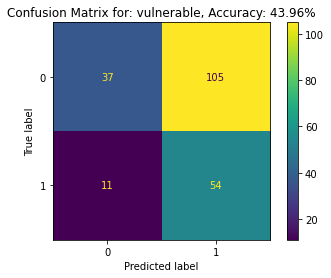

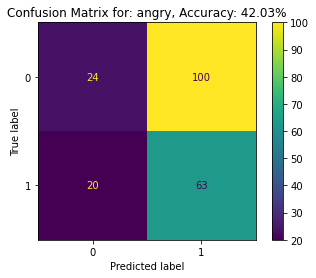

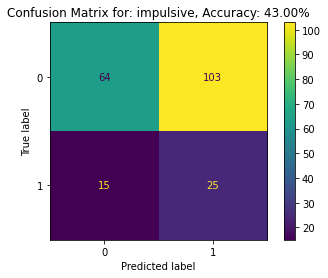

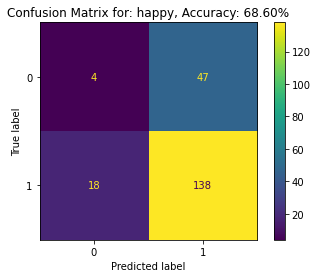

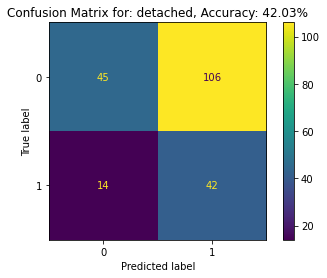

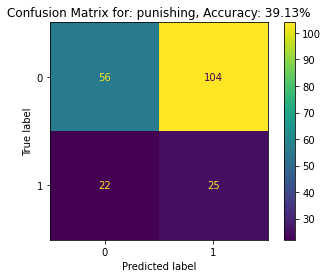

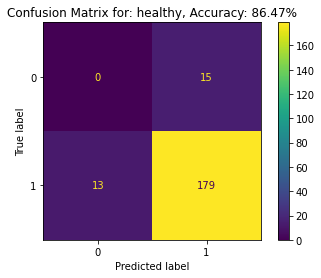

In [3]:
def per_questionnaire_rbf():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_range_of_label(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    # from sklearn import preprocessing
    # x_train = preprocessing.scale(x_train) 
    #  C=0.1, gamma=0.1, degree=4
    model_to_set = svm.SVC(kernel="rbf", class_weight='balanced')
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    each_accuracy = []

    y_test_bin = myutils.rank_the_labels(y_test)
    schema_test_pred_bin = myutils.rank_the_labels(schema_test_pred)
    y_test_bin = np.array(y_test_bin)
    schema_test_pred_bin = np.array(schema_test_pred_bin)

    print("Accuracy: ", accuracy_score(y_test_bin, schema_test_pred_bin))
    print('F1 Score: ', f1_score(y_test_bin, schema_test_pred_bin, average='weighted'))

    clf_report = classification_report(y_test_bin, schema_test_pred_bin, target_names=schemas)
    print(clf_report)
    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))

    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test_bin, schema_test_pred_bin)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test_bin)).plot()
        accuracy_calc = accuracy_score(y_true=y_test_bin[:,i-1], y_pred=schema_test_pred_bin[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.show()
        i += 1
    
    # print("Schemas: ", schemas)
    # # print("Sum:", np.sum(y_train, axis=0))
    # print("Accuracy: ", each_accuracy)
per_questionnaire_rbf()

Accuracy:  0.42995169082125606
F1 Score:  0.5048879025294868
              precision    recall  f1-score   support

  vulnerable       0.00      0.00      0.00        65
       angry       0.00      0.00      0.00        83
   impulsive       0.33      0.03      0.05        40
       happy       0.75      1.00      0.86       156
    detached       0.33      0.02      0.03        56
   punishing       0.00      0.00      0.00        47
     healthy       0.93      1.00      0.96       192

   micro avg       0.83      0.55      0.66       639
   macro avg       0.34      0.29      0.27       639
weighted avg       0.51      0.55      0.50       639
 samples avg       0.83      0.67      0.71       639

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
vulnerable & 0.0 & 0.0 & 0.0 & 65\\
angry & 0.0 & 0.0 & 0.0 & 83\\
impulsive & 0.33 & 0.03 

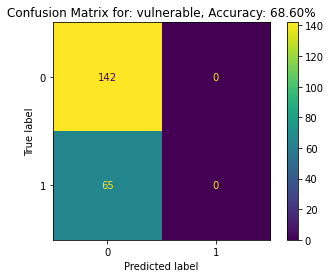

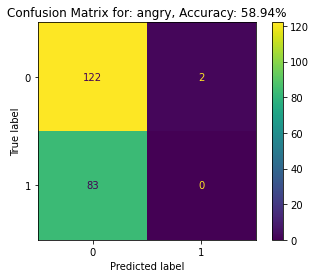

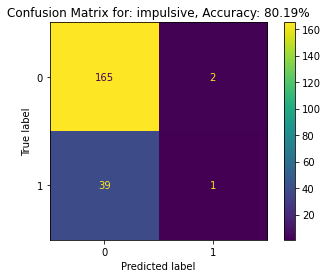

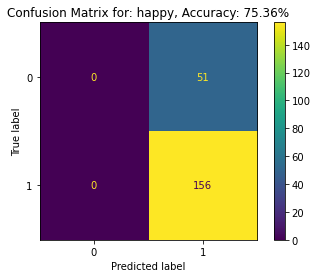

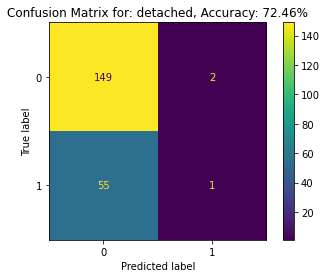

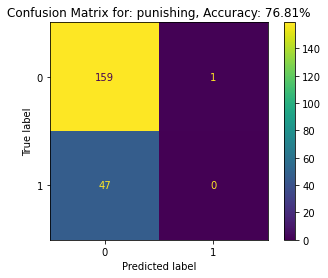

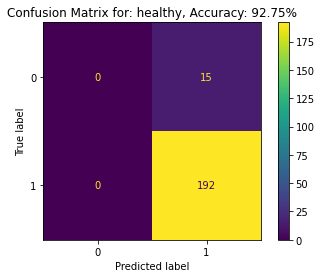

In [4]:
def per_questionnaire_linear():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_range_of_label(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    # from sklearn import preprocessing
    # x_train = preprocessing.scale(x_train) 
    #  C=0.1, gamma=0.1, degree=4
    model_to_set = svm.SVC(kernel="linear")
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    each_accuracy = []

    y_test_bin = myutils.rank_the_labels(y_test)
    schema_test_pred_bin = myutils.rank_the_labels(schema_test_pred)
    y_test_bin = np.array(y_test_bin)
    schema_test_pred_bin = np.array(schema_test_pred_bin)

    print("Accuracy: ", accuracy_score(y_test_bin, schema_test_pred_bin))
    print('F1 Score: ', f1_score(y_test_bin, schema_test_pred_bin, average='weighted'))

    clf_report = classification_report(y_test_bin, schema_test_pred_bin, target_names=schemas)
    print(clf_report)
    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))

    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test_bin, schema_test_pred_bin)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test_bin)).plot()
        accuracy_calc = accuracy_score(y_true=y_test_bin[:,i-1], y_pred=schema_test_pred_bin[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.show()
        i += 1
    
    # print("Schemas: ", schemas)
    # # print("Sum:", np.sum(y_train, axis=0))
    # print("Accuracy: ", each_accuracy)
per_questionnaire_linear()